# Training process 4
+ Model name：`Training_4_Res_NLLLoss_1FC_100e.pt` ; 
+ Path： '`./model/Training_4_Res_NLLLoss_1FC_100e.pt`'
+ Training network：`resnet50 with One fully connected layers`
+ Loss function：`NLLLoss`
+ Optimizer： `Adam`
+ epoch： `100`
+ sample pairing: `False ` 

### Data Preparation

In [1]:
import torch
import torchvision
from torchvision import datasets,transforms 
from face_crop import face_crop


train_dir = './data/face_data/train/'
valid_dir = './data/face_data/val/'

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
    transforms.RandomErasing(),
])


valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                           shuffle=True, num_workers=4)


valid_data = datasets.ImageFolder(root=valid_dir,
                                transform=valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                          shuffle=True, num_workers=4)


In [2]:
train_data

Dataset ImageFolder
    Number of datapoints: 10481
    Root location: ./data/face_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [3]:
valid_data

Dataset ImageFolder
    Number of datapoints: 6821
    Root location: ./data/face_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
class_names = train_data.classes

In [5]:
import random
from PIL import Image
import numpy as np
import torchvision.datasets as vdatasets


class SamplePairing(object):
    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, img_a, img_b):
        # 0.5 samplepairing
        toss = np.random.choice([1, 0], p=[self.p, 1 - self.p])
        
        if toss:
            img_a_array = img_a.numpy().copy()
            img_b_array = img_b.numpy().copy()
            
            # mix two images
            mean_img = np.mean([img_a_array, img_b_array], axis=0)
            img = torch.from_numpy(mean_img)
        
            return img
        else:
            return img_a

/home/wang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


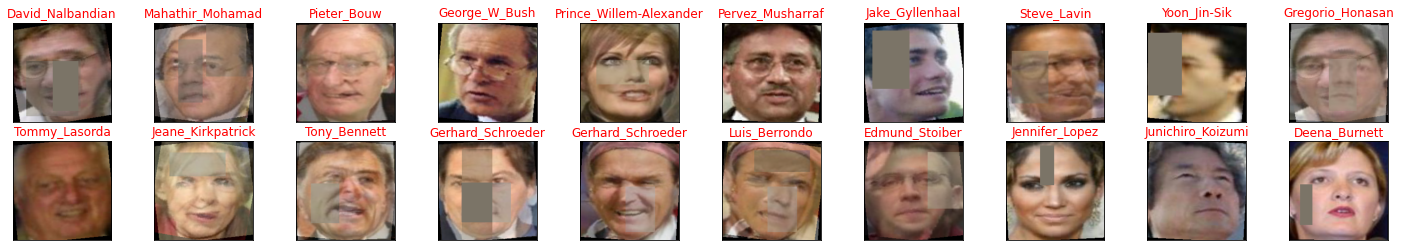

In [6]:
#Transform Data visualize
import numpy as np
import matplotlib.pyplot as plt
images, classes = next(iter(train_loader))

for i in range(images.shape[0]):
    image_sample = SamplePairing()
    image_a = images[i]
    image_b = images[np.random.randint(0, images.shape[0])]
    images[i] = image_sample(image_a, image_b)

def imshow(inp):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    

fig = plt.figure(figsize=(25, 4))
    # display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]], color='red') 

### Training Network

In [6]:
# Resnet50 with One fully connected layers
from torchvision import models
from torch import nn
from collections import OrderedDict

model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc', nn.Linear(2048, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the classifier part of the introduced net!
model_resnet50.fc = classifier

In [7]:
#model_resnet50

## Trainning process

In [8]:
import torch 
import torch.nn.functional as F
from torch import nn, optim  
from tqdm import tqdm
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model='resnet50', data_augumentation=False, loss='NLLLoss', lr=0.003, weight_decay=1e-5, epoch=None):
    if model == 'model_resnet50':
        model = model_resnet50
    
    model.to(device)
    
    if data_augumentation:
        pass
        
    if loss == 'NLLLoss':
        print('use NLLLoss')
        criterion = nn.NLLLoss()
        
    if loss == 'FocalLoss':
        print('use focal loss')
        criterion = FocalLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    
    
    
    epochs = epoch
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf

    for e in range(epochs):
        train_loss = 0
        valid_loss = 0
        accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            if data_augumentation == 'samplePairing' and e+1 >= epochs * 0.2 and e+1 < epochs * 0.8:
                # do sample pairing for every image
                for i in range(images.shape[0]):
                    image_sample = SamplePairing()
                    image_a = images[i]
                    image_b = images[np.random.randint(0, images.shape[0])]
                    # images[i] is of type tensor, and both inputs are of type tensor
                    images[i] = image_sample(image_a, image_b)
                    
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss = loss.requires_grad_()
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()  # Close dropout
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Verify loss
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
                # Verify accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # An epoch loss 
        train_loss = train_loss/len(train_loader.sampler)   
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = accuracy / len(valid_loader)

        # Add the loss to the list for graphing
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Add the code to save this list to the local to use this loss transformation list when not training in the future, 
        # such as comparing different models
        train_loss_array = np.array(train_losses)
        valid_loss_array = np.array(valid_losses)
        valid_accuracy_array = np.array(valid_accuracy)
        
        
        np.save('./results/Training_4/Ftp4_train_loss_array.npy', train_loss_array)
        np.save('./results/Training_4/Ftp4_valid_loss_array.npy', valid_loss_array)
        np.save('./results/Training_4/Ftp4_valid_accuracy_array.npy', valid_accuracy_array)
        
   
        # Print an epoch information
        print('Epoch {}/{}..'.format(e + 1, epochs),
              'Train loss:{:.4f}..'.format(train_loss),
              'Valid loss:{:.4f}..'.format(valid_loss),
              'Valid accuracy:{:.4f}%..'.format(valid_accuracy * 100))
        
        # Save the optimal model
        if valid_loss <= valid_loss_min:
            print('valid_loss decreased: ({:.4f} --> {:.4f}), saving model "Training_4_Res_NLLLoss_1FC_100e.pt"..'.format(valid_loss_min, valid_loss))
            torch.save(model, './model/Training_4_Res_NLLLoss_1FC_100e.pt')
            valid_loss_min = valid_loss

In [11]:
train(model='model_resnet50', data_augumentation=False, loss='NLLLoss', lr=0.001, weight_decay=1e-5, epoch=100)

  0%|          | 0/82 [00:00<?, ?it/s]

use NLLLoss


100%|██████████| 107/107 [02:08<00:00,  1.20s/it]
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of 

Epoch 1/100.. Train loss:10.0408.. Valid loss:8.6053.. Valid accuracy:1.7192%..
valid_loss decreased: (inf --> 8.6053), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [02:07<00:00,  1.19s/it]


Epoch 2/100.. Train loss:8.1386.. Valid loss:8.0875.. Valid accuracy:3.2564%..
valid_loss decreased: (8.6053 --> 8.0875), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/100.. Train loss:7.4642.. Valid loss:7.4989.. Valid accuracy:4.5509%..
valid_loss decreased: (8.0875 --> 7.4989), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 4/100.. Train loss:6.8691.. Valid loss:6.9103.. Valid accuracy:7.5019%..
valid_loss decreased: (7.4989 --> 6.9103), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 5/100.. Train loss:6.3524.. Valid loss:6.4730.. Valid accuracy:10.8672%..
valid_loss decreased: (6.9103 --> 6.4730), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 6/100.. Train loss:5.8770.. Valid loss:6.0183.. Valid accuracy:14.5393%..
valid_loss decreased: (6.4730 --> 6.0183), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.06s/it]


Epoch 7/100.. Train loss:5.4346.. Valid loss:5.6285.. Valid accuracy:19.1924%..
valid_loss decreased: (6.0183 --> 5.6285), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 8/100.. Train loss:5.0355.. Valid loss:5.2406.. Valid accuracy:24.5611%..
valid_loss decreased: (5.6285 --> 5.2406), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 9/100.. Train loss:4.6431.. Valid loss:4.8741.. Valid accuracy:30.1591%..
valid_loss decreased: (5.2406 --> 4.8741), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 10/100.. Train loss:4.2857.. Valid loss:4.6387.. Valid accuracy:35.3565%..
valid_loss decreased: (4.8741 --> 4.6387), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.06s/it]


Epoch 11/100.. Train loss:4.0101.. Valid loss:4.3358.. Valid accuracy:38.7669%..
valid_loss decreased: (4.6387 --> 4.3358), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 12/100.. Train loss:3.7351.. Valid loss:4.1488.. Valid accuracy:41.4566%..
valid_loss decreased: (4.3358 --> 4.1488), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 13/100.. Train loss:3.4586.. Valid loss:3.9293.. Valid accuracy:45.7632%..
valid_loss decreased: (4.1488 --> 3.9293), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 14/100.. Train loss:3.2280.. Valid loss:3.7238.. Valid accuracy:49.4127%..
valid_loss decreased: (3.9293 --> 3.7238), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 15/100.. Train loss:3.0283.. Valid loss:3.6028.. Valid accuracy:51.8313%..
valid_loss decreased: (3.7238 --> 3.6028), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 16/100.. Train loss:2.8843.. Valid loss:3.4889.. Valid accuracy:53.5252%..
valid_loss decreased: (3.6028 --> 3.4889), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 17/100.. Train loss:2.7204.. Valid loss:3.3850.. Valid accuracy:55.6667%..
valid_loss decreased: (3.4889 --> 3.3850), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 18/100.. Train loss:2.5561.. Valid loss:3.3100.. Valid accuracy:56.4817%..
valid_loss decreased: (3.3850 --> 3.3100), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 19/100.. Train loss:2.4429.. Valid loss:3.2456.. Valid accuracy:57.5532%..
valid_loss decreased: (3.3100 --> 3.2456), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 20/100.. Train loss:2.3104.. Valid loss:3.1698.. Valid accuracy:58.5592%..
valid_loss decreased: (3.2456 --> 3.1698), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 21/100.. Train loss:2.2304.. Valid loss:3.1482.. Valid accuracy:58.8209%..
valid_loss decreased: (3.1698 --> 3.1482), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 22/100.. Train loss:2.1410.. Valid loss:3.0959.. Valid accuracy:59.9307%..
valid_loss decreased: (3.1482 --> 3.0959), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 23/100.. Train loss:2.0414.. Valid loss:3.0690.. Valid accuracy:60.9928%..
valid_loss decreased: (3.0959 --> 3.0690), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 24/100.. Train loss:2.0118.. Valid loss:3.0615.. Valid accuracy:60.5278%..
valid_loss decreased: (3.0690 --> 3.0615), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 25/100.. Train loss:1.9557.. Valid loss:3.0500.. Valid accuracy:61.6313%..
valid_loss decreased: (3.0615 --> 3.0500), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 26/100.. Train loss:1.9002.. Valid loss:2.9973.. Valid accuracy:61.5078%..
valid_loss decreased: (3.0500 --> 2.9973), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 27/100.. Train loss:1.8200.. Valid loss:3.0000.. Valid accuracy:61.9538%..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 28/100.. Train loss:1.7828.. Valid loss:2.9464.. Valid accuracy:63.0506%..
valid_loss decreased: (2.9973 --> 2.9464), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.06s/it]


Epoch 29/100.. Train loss:1.7677.. Valid loss:2.9231.. Valid accuracy:63.3174%..
valid_loss decreased: (2.9464 --> 2.9231), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 30/100.. Train loss:1.6866.. Valid loss:2.9790.. Valid accuracy:62.8738%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 31/100.. Train loss:1.6481.. Valid loss:2.9355.. Valid accuracy:63.0715%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 32/100.. Train loss:1.5851.. Valid loss:2.9392.. Valid accuracy:63.2921%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 33/100.. Train loss:1.5779.. Valid loss:2.9281.. Valid accuracy:63.4342%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 34/100.. Train loss:1.5459.. Valid loss:2.9328.. Valid accuracy:63.2428%..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 35/100.. Train loss:1.5217.. Valid loss:2.8880.. Valid accuracy:64.6036%..
valid_loss decreased: (2.9231 --> 2.8880), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 36/100.. Train loss:1.4776.. Valid loss:2.8698.. Valid accuracy:64.6967%..
valid_loss decreased: (2.8880 --> 2.8698), saving model "Formal_training_process1_model_resnet50_nnlose_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 37/100.. Train loss:1.4511.. Valid loss:2.8962.. Valid accuracy:64.3794%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 38/100.. Train loss:1.4491.. Valid loss:2.9267.. Valid accuracy:64.1442%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 39/100.. Train loss:1.4151.. Valid loss:2.8951.. Valid accuracy:64.6648%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 40/100.. Train loss:1.3850.. Valid loss:2.9249.. Valid accuracy:64.2598%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 41/100.. Train loss:1.3703.. Valid loss:2.9097.. Valid accuracy:64.4710%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 42/100.. Train loss:1.3754.. Valid loss:2.9198.. Valid accuracy:64.1497%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 43/100.. Train loss:1.3302.. Valid loss:2.9099.. Valid accuracy:64.3593%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 44/100.. Train loss:1.2942.. Valid loss:2.8968.. Valid accuracy:65.4162%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 45/100.. Train loss:1.2779.. Valid loss:2.9516.. Valid accuracy:64.3435%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 46/100.. Train loss:1.2880.. Valid loss:2.9100.. Valid accuracy:65.1719%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 47/100.. Train loss:1.2808.. Valid loss:2.9570.. Valid accuracy:64.5637%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 48/100.. Train loss:1.2599.. Valid loss:2.9293.. Valid accuracy:65.3550%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 49/100.. Train loss:1.2527.. Valid loss:2.9533.. Valid accuracy:64.6900%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 50/100.. Train loss:1.2710.. Valid loss:2.9561.. Valid accuracy:64.9276%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 51/100.. Train loss:1.2160.. Valid loss:2.9516.. Valid accuracy:64.6766%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 52/100.. Train loss:1.2003.. Valid loss:2.9211.. Valid accuracy:65.3377%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 53/100.. Train loss:1.1736.. Valid loss:2.9456.. Valid accuracy:65.3006%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 54/100.. Train loss:1.1843.. Valid loss:2.9768.. Valid accuracy:64.9647%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 55/100.. Train loss:1.1830.. Valid loss:2.9829.. Valid accuracy:65.0539%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 56/100.. Train loss:1.1649.. Valid loss:2.9660.. Valid accuracy:65.5449%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 57/100.. Train loss:1.1798.. Valid loss:2.9631.. Valid accuracy:65.4691%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 58/100.. Train loss:1.1602.. Valid loss:2.9710.. Valid accuracy:65.4123%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 59/100.. Train loss:1.1247.. Valid loss:3.0157.. Valid accuracy:64.5361%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 60/100.. Train loss:1.1375.. Valid loss:2.9589.. Valid accuracy:65.7280%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 61/100.. Train loss:1.1232.. Valid loss:2.9746.. Valid accuracy:65.5820%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 62/100.. Train loss:1.1045.. Valid loss:2.9663.. Valid accuracy:65.8476%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 63/100.. Train loss:1.0998.. Valid loss:2.9502.. Valid accuracy:65.3507%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 64/100.. Train loss:1.0710.. Valid loss:2.9806.. Valid accuracy:65.6364%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 65/100.. Train loss:1.0766.. Valid loss:3.0266.. Valid accuracy:65.0484%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 66/100.. Train loss:1.0774.. Valid loss:2.9753.. Valid accuracy:65.7864%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 67/100.. Train loss:1.0660.. Valid loss:3.0032.. Valid accuracy:65.5409%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 68/100.. Train loss:1.0572.. Valid loss:3.0120.. Valid accuracy:65.3922%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 69/100.. Train loss:1.0868.. Valid loss:3.0102.. Valid accuracy:65.4865%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 70/100.. Train loss:1.0377.. Valid loss:3.0435.. Valid accuracy:65.5196%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 71/100.. Train loss:1.0449.. Valid loss:3.0538.. Valid accuracy:65.2927%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 72/100.. Train loss:1.0541.. Valid loss:2.9892.. Valid accuracy:65.9538%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 73/100.. Train loss:1.0407.. Valid loss:3.0274.. Valid accuracy:65.8780%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 74/100.. Train loss:1.0217.. Valid loss:3.0386.. Valid accuracy:66.0043%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 75/100.. Train loss:1.0333.. Valid loss:3.0258.. Valid accuracy:65.7280%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 76/100.. Train loss:0.9795.. Valid loss:3.0535.. Valid accuracy:65.5516%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 77/100.. Train loss:1.0204.. Valid loss:3.0537.. Valid accuracy:65.5184%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 78/100.. Train loss:0.9949.. Valid loss:3.0314.. Valid accuracy:66.0335%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 79/100.. Train loss:0.9837.. Valid loss:3.0575.. Valid accuracy:65.6274%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 80/100.. Train loss:0.9508.. Valid loss:3.0363.. Valid accuracy:65.8981%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 81/100.. Train loss:1.0012.. Valid loss:3.0483.. Valid accuracy:65.9818%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 82/100.. Train loss:0.9842.. Valid loss:3.0646.. Valid accuracy:65.9127%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 83/100.. Train loss:0.9662.. Valid loss:3.0401.. Valid accuracy:66.2991%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 84/100.. Train loss:0.9886.. Valid loss:3.0595.. Valid accuracy:65.7031%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 85/100.. Train loss:0.9767.. Valid loss:3.0152.. Valid accuracy:66.5766%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 86/100.. Train loss:0.9582.. Valid loss:3.0617.. Valid accuracy:66.0043%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 87/100.. Train loss:0.9698.. Valid loss:3.1240.. Valid accuracy:65.6258%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 88/100.. Train loss:0.9154.. Valid loss:3.0822.. Valid accuracy:66.0627%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 89/100.. Train loss:0.9681.. Valid loss:3.0959.. Valid accuracy:66.0785%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 90/100.. Train loss:0.9514.. Valid loss:3.0788.. Valid accuracy:66.3121%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 91/100.. Train loss:0.9291.. Valid loss:3.0815.. Valid accuracy:66.2525%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 92/100.. Train loss:0.9279.. Valid loss:3.0288.. Valid accuracy:66.8236%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 93/100.. Train loss:0.9221.. Valid loss:3.0559.. Valid accuracy:66.3161%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 94/100.. Train loss:0.9223.. Valid loss:3.0791.. Valid accuracy:65.6775%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 95/100.. Train loss:0.9510.. Valid loss:3.0351.. Valid accuracy:66.4463%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 96/100.. Train loss:0.9087.. Valid loss:3.0566.. Valid accuracy:66.4250%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 97/100.. Train loss:0.9093.. Valid loss:3.0382.. Valid accuracy:66.7597%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 98/100.. Train loss:0.8830.. Valid loss:3.1173.. Valid accuracy:65.8409%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 99/100.. Train loss:0.9008.. Valid loss:3.0790.. Valid accuracy:66.2975%..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]

Epoch 100/100.. Train loss:0.9018.. Valid loss:3.0926.. Valid accuracy:65.9471%..


### Loss visualization

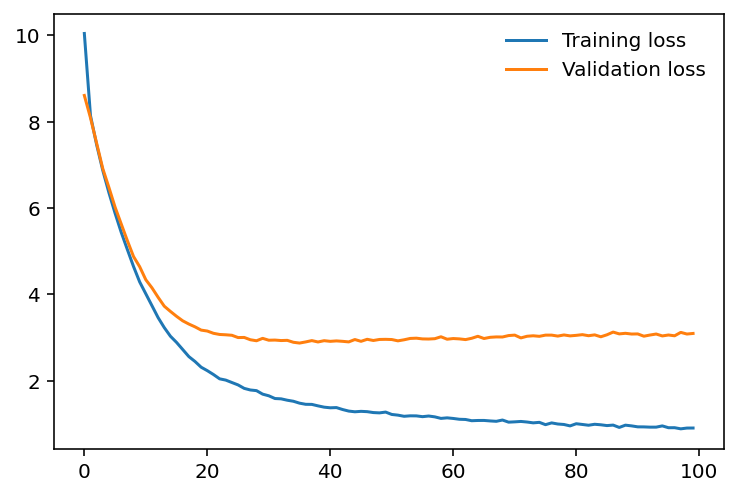

In [12]:
train_losses = np.load('./results/Training_4/Ftp4_train_loss_array.npy')
valid_losses = np.load('./results/Training_4/Ftp4_valid_loss_array.npy')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

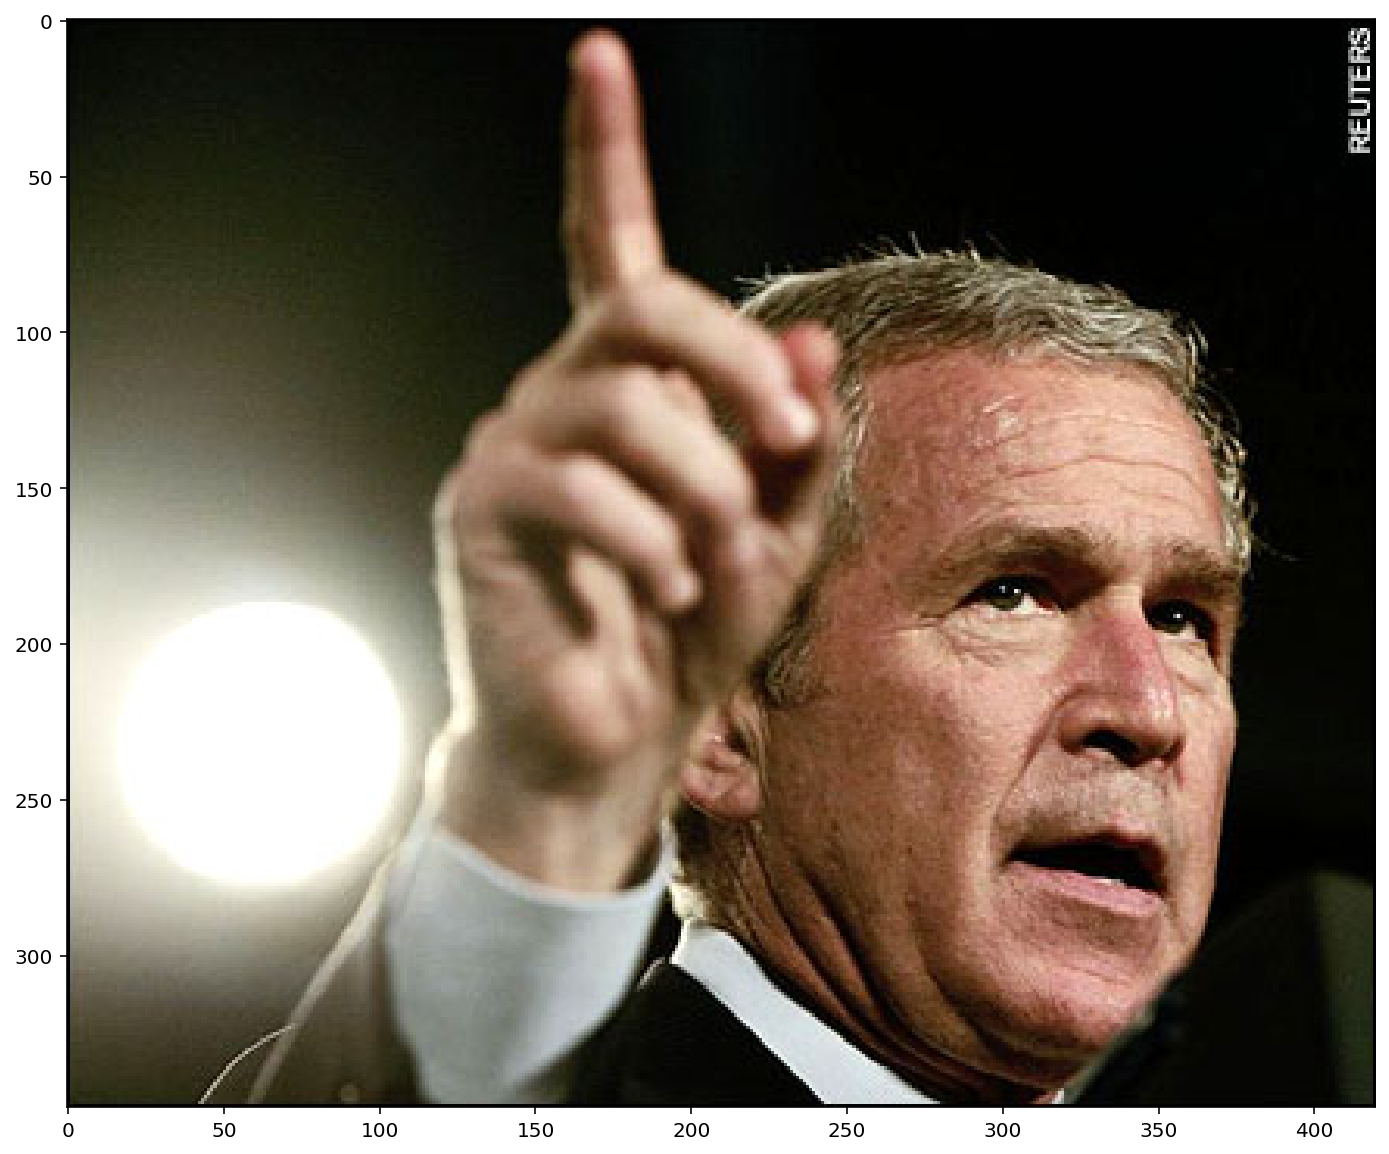

In [13]:
img_path = './data/face_test/big_bushi2.jpg'

# Read test picture
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(48, 10)) # Set canvas size

img = Image.open(img_path)
plt.imshow(img)

In [14]:
import torch
model_path = './model/Training_4_Res_NLLLoss_1FC_100e.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model=torch.load(model_path)
model.to(device);

In [15]:
from face_crop import face_crop
from torchvision import datasets,transforms 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = Image.open(img_path)

valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])



transformed_image = valid_transform(img).float()
with torch.no_grad():
    transformed_image = transformed_image
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    outputs = model(transformed_image)
#         plt.imshow(transformed_image)
#         print(transformed_image)
outputs = torch.exp(outputs)

In [16]:
top_p, top_k = torch.topk(outputs, 10, dim=1, largest=True, sorted=True, out=None)

In [17]:
import numpy as np
class_names = np.load("class_names.npy")

In [18]:
print('The most similar person is {}.'.format(class_names[top_k[0][0].item()]))
print('Similarity is {:.2%}'.format(top_p[0][0].item()))
print('\n')
print('The second similar person is {}.'.format(class_names[top_k[0][1].item()]))
print('Similarity is {:.2%}'.format(top_p[0][1].item()))
print('\n')
print('The third similar person is {}.'.format(class_names[top_k[0][2].item()]))
print('Similarity is {:.2%}'.format(top_p[0][2].item()))

The most similar person is George_W_Bush.
Similarity is 35.73%


The second similar person is Tom_Ridge.
Similarity is 6.65%


The third similar person is Geoff_Hoon.
Similarity is 6.23%
